In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
train = pd.read_csv(r'''D:\CHIRAG\Kaggle\Titanic\train.csv''')
train['label'] = 'train'
test = pd.read_csv(r'''D:\CHIRAG\Kaggle\Titanic\test.csv''')
test['label'] = 'test'
test_passengerId = test.PassengerId  #Save test passengerId. It will be required at the end
df = train.append(test)
df.sample(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,label
290,26.0,NaN,S,78.85,"Barber, Miss. Ellen ""Nellie""",0,291,1,female,0,1.0,19877,train
70,32.0,NaN,S,10.50,"Jenkin, Mr. Stephen Curnow",0,71,2,male,0,0.0,C.A. 33111,train


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
label          1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


In [6]:
df.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
label             0
dtype: int64

So we have to handle missing values of age, cabin, embarked and fare. Survived has missing values of test set.

In [7]:
df.describe(include = 'all')

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,label
count,1046.000000,295,1307,1308.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,891.000000,1309,1309
unique,NaN,186,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929,2
top,NaN,C23 C25 C27,S,NaN,"Kelly, Mr. James",NaN,NaN,NaN,male,NaN,NaN,CA. 2343,train
freq,NaN,6,914,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11,891
mean,29.881138,NaN,NaN,33.295479,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.383838,NaN,NaN
std,14.413493,NaN,NaN,51.758668,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486592,NaN,NaN
min,0.170000,NaN,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN,NaN
25%,21.000000,NaN,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN,NaN
50%,28.000000,NaN,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN,NaN
75%,39.000000,NaN,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN,NaN


### Handling Missing Values

#### Embarked

In [8]:
#Fill missing value
df['Embarked'].fillna('S', inplace = True)    #top value with freq 914

#### Fare

In [9]:
df[df.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,label
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,test


In [10]:
df.corr().Fare

Age            0.178740
Fare           1.000000
Parch          0.221539
PassengerId    0.031428
Pclass        -0.558629
SibSp          0.160238
Survived       0.257307
Name: Fare, dtype: float64

Looks like Pclass can help to fill the missing value.

In [11]:
print(df[df.Pclass == 1].Fare.quantile([0.25, 0.50, 0.75]))
print(df[df.Pclass == 2].Fare.quantile([0.25, 0.50, 0.75]))
print(df[df.Pclass == 3].Fare.quantile([0.25, 0.50, 0.75]))

0.25     30.6958
0.50     60.0000
0.75    107.6625
Name: Fare, dtype: float64
0.25    13.0000
0.50    15.0458
0.75    26.0000
Name: Fare, dtype: float64
0.25     7.7500
0.50     8.0500
0.75    15.2458
Name: Fare, dtype: float64


Yup! Values differ totally according to Pclass. Let's look it through visualization.

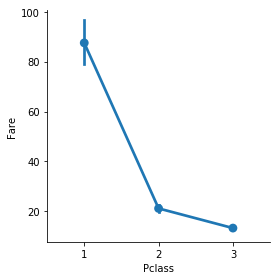

In [12]:
sns.factorplot(x = 'Pclass', y = 'Fare', data = df)

In [13]:
df['Fare'].fillna(df[df.Pclass == 3].Fare.median(), inplace = True)   #Fare is dependent on Pclass

#### Age

In [14]:
print("Age column has", df.Age.isnull().sum(), "missing values out of", len(df), ". Missing value percentage =", df.Age.isnull().sum()/len(df)*100)

Age column has 263 missing values out of 1309 . Missing value percentage = 20.091673032849503


Its high! Thus any value derived statistically (mean or median) based on only Age column can mislead the dataset for the classifier. We will fill them based on the relations with other variables.

In [15]:
df.corr().Age

Age            1.000000
Fare           0.177286
Parch         -0.150917
PassengerId    0.028814
Pclass        -0.408106
SibSp         -0.243699
Survived      -0.077221
Name: Age, dtype: float64

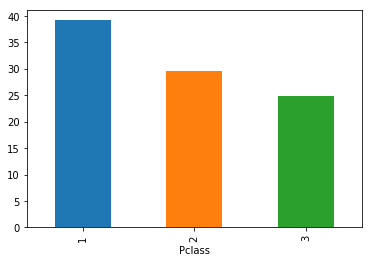

In [16]:
df.pivot_table(values = 'Age', index = 'Pclass').Age.plot.bar()

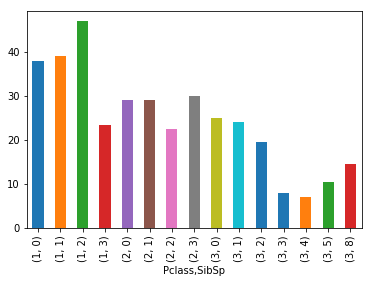

In [17]:
df.pivot_table(values = 'Age', index = ['Pclass', 'SibSp'], aggfunc = 'median').Age.plot.bar()

A basic trend can be found from the graph. Thus, we are on right path!

In [18]:
df.pivot_table(values = 'Age', index = ['Pclass', 'SibSp', 'Parch'], aggfunc = 'median')

Age
Pclass SibSp Parch       
1      0     0      39.00
             1      37.50
             2      22.00
       1     0      38.00
             1      49.00
             2      25.00
             3      54.50
             4      62.00
       2     0      53.00
             2      18.00
       3     2      23.50
2      0     0      30.00
             1      26.50
             2      18.00
             3      36.00
       1     0      29.50
             1      24.00
             2      24.00
             3      54.00
       2     0      24.00
             1      16.00
             3      24.00
       3     0      30.00
3      0     0      25.00
             1      17.00
             2      26.00
             3      24.00
             4      29.00
             5      40.00
       1     0      25.00
             1      16.00
             2      13.50
             3      32.00
             4      42.50
             5      39.00
             6      41.50
             9        NaN
       2     0      23.00
             1       0.75
             2      18.00
       3     0      32.00
             1       6.00
             2       6.50
       4     1       7.00
             2       7.50
       5     2      10.50
       8     2      14.50

We will fill missing values based on Pclass and SibSp.

In [19]:
df.Age.isnull().sum()

263

In [20]:
age_null = df.Age.isnull()
group_med_age = df.pivot_table(values = 'Age', index = ['Pclass', 'SibSp'], aggfunc = 'median')
df.loc[age_null, 'Age'] = df.loc[age_null, ['Pclass', 'SibSp']].apply(lambda x: group_med_age.loc[(group_med_age.index.get_level_values('Pclass') == x.Pclass) & (group_med_age.index.get_level_values('SibSp') == x.SibSp)].Age.values[0], axis = 1)

In [21]:
df.Age.isnull().sum()

0

#### Cabin

In [22]:
print("Cabin has", df.Cabin.isnull().sum(), "missing values out of", len(df))

Cabin has 1014 missing values out of 1309


So instead of filling those values, form their cluster. We will assume that those people don't have cabin.

In [23]:
df['Cabin'] = df.Cabin.str[0]
df.Cabin.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [24]:
df.Cabin.fillna('O', inplace = True)

In [25]:
df.isnull().sum()

Age              0
Cabin            0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
label            0
dtype: int64

So, we are done with data cleaning part. Missing Survived are from test set.

In [26]:
df.sample(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,label
299,29.0,O,S,7.8542,"Johansson, Mr. Nils",0,1191,3,male,0,NaN,347467,test
688,18.0,O,S,7.7958,"Fischer, Mr. Eberhard Thelander",0,689,3,male,0,0.0,350036,train


### Sex

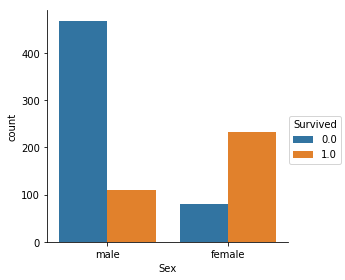

In [27]:
sns.factorplot(data = df, x = 'Sex', hue = 'Survived', kind = 'count')

Text(0,0.5,'Survival Probability')

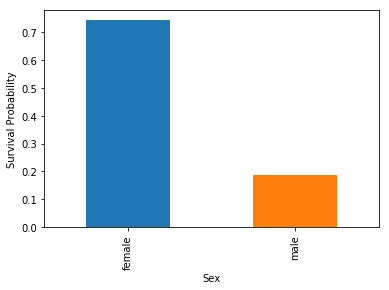

In [28]:
df.pivot_table(values = 'Survived', index = 'Sex').Survived.plot.bar()
plt.ylabel('Survival Probability')

Females tend to survive more than males.

#### Age

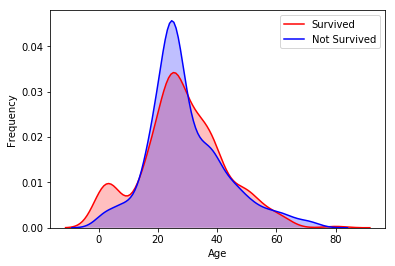

In [29]:
q = sns.kdeplot(df.Age[df.Survived == 1], shade = True, color = 'red')
q = sns.kdeplot(df.Age[df.Survived == 0], shade = True, color = 'blue')
q.set_xlabel("Age")
q.set_ylabel("Frequency")
q = q.legend(['Survived', 'Not Survived'])

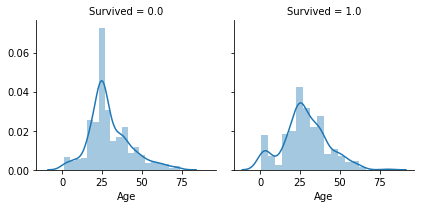

In [30]:
q = sns.FacetGrid(df, col = 'Survived')
q.map(sns.distplot, 'Age')

#### Embarked

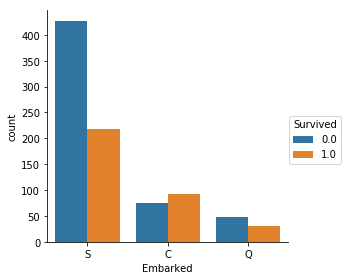

In [31]:
sns.factorplot(data = df, x = 'Embarked', hue = 'Survived', kind = 'count')

Text(0,0.5,'Survival Probability')

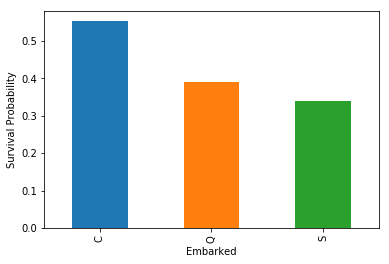

In [32]:
df.pivot_table(values = 'Survived', index = 'Embarked').Survived.plot.bar()
plt.ylabel('Survival Probability')

Cherbourg port is more save as compared to others. Lets look more into this.

Text(0,0.5,'Survival Probability')

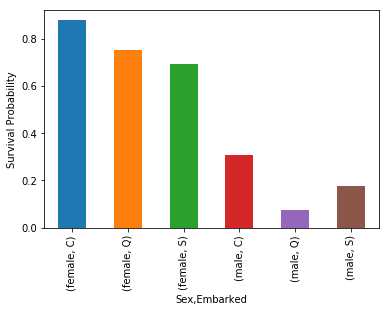

In [33]:
df.pivot_table(values = 'Survived', index = ['Sex','Embarked']).Survived.plot.bar()
plt.ylabel('Survival Probability')

We found something interesting! Cherbourg port is very safe for females and Qweenstone and Southampton ports are very dangerous for males.

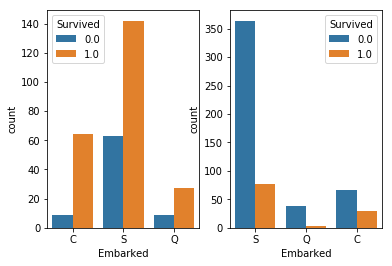

In [34]:
fig, ax =plt.subplots(1,2)
sns.countplot(data = df[df.Sex == 'female'], x = 'Embarked', hue = 'Survived', ax = ax[0])
sns.countplot(data = df[df.Sex == 'male'], x = 'Embarked', hue = 'Survived', ax = ax[1])
fig.show()

Surprised! Port of embarkation is very safe for females  but more dangerous form males. Similarly other two ports also contradict for males and females.

#### Parch

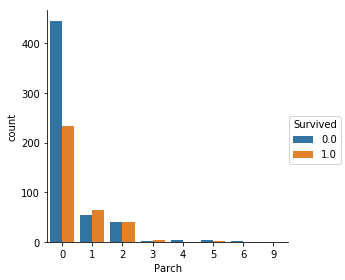

In [35]:
sns.factorplot(data = df, x = 'Parch', hue = 'Survived', kind = 'count')

Text(0,0.5,'Survival Probability')

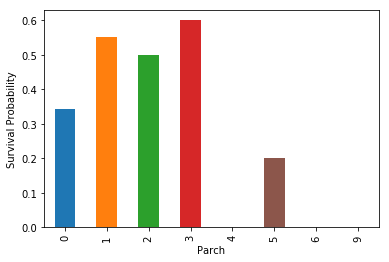

In [36]:
df.pivot_table(values = 'Survived', index = 'Parch').Survived.plot.bar()
plt.ylabel('Survival Probability')

#### Pclass

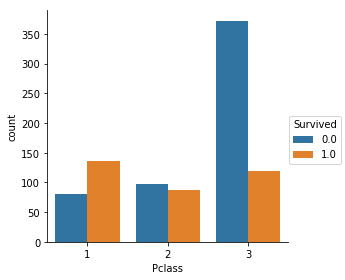

In [37]:
sns.factorplot(data = df, x = 'Pclass', hue = 'Survived', kind = 'count')

Text(0,0.5,'Survival Probability')

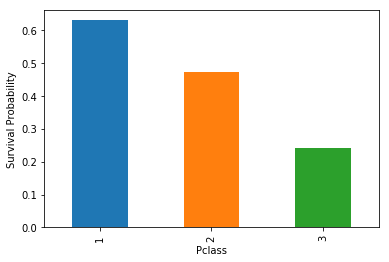

In [38]:
df.pivot_table(values = 'Survived', index = 'Pclass').Survived.plot.bar()
plt.ylabel('Survival Probability')

Text(0,0.5,'Survival Probability')

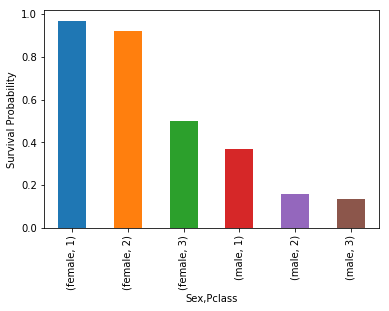

In [39]:
df.pivot_table(values = 'Survived', index = ['Sex', 'Pclass']).Survived.plot.bar()
plt.ylabel('Survival Probability')

Qualty of tickets class assures more safety!

#### Cabin

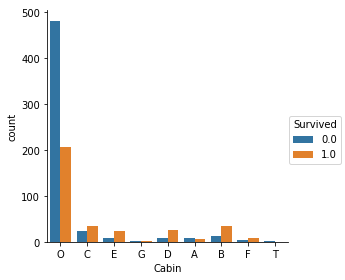

In [40]:
sns.factorplot(data = df, x = 'Cabin', hue = 'Survived', kind = 'count')

Text(0,0.5,'Survival Probability')

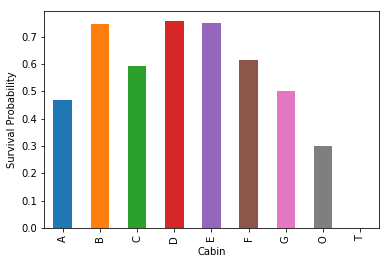

In [41]:
df.pivot_table(values = 'Survived', index = 'Cabin').Survived.plot.bar()
plt.ylabel('Survival Probability')

#### Fare

From dataset description, it was clear that Fare values are not skewed. Lets visualize it.

Text(0,0.5,'Fares')

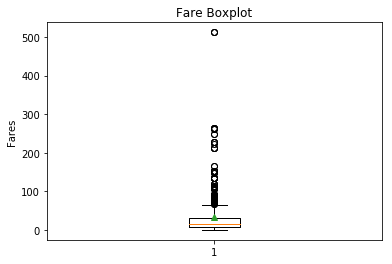

In [42]:
plt.boxplot(train.Fare, showmeans = True)
plt.title('Fare Boxplot')
plt.ylabel('Fares')

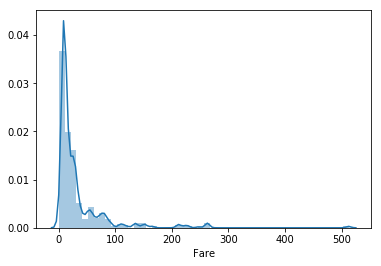

In [43]:
sns.distplot(df.Fare)

Highly right skewed!

In [44]:
df.Fare.skew()    #Measure of skewness level

4.369213744046745

We will take log transform. This might help classifier in preditions. Also it will help us to find correlation between variables.

In [45]:
df['Fare_log'] = df.Fare.map(lambda i: np.log(i) if i > 0 else 0)

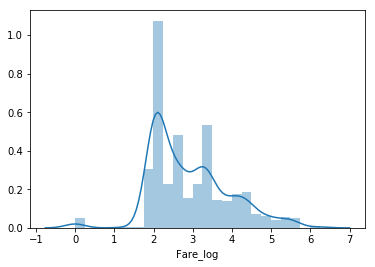

In [46]:
sns.distplot(df.Fare_log)

In [47]:
df.Fare_log.skew()

0.5699550601371423

### Feature Engineering

In [48]:
df['Family_size'] = 1 + df.Parch + df.SibSp
df['Alone'] = np.where(df.Family_size == 1, 1, 0)

In [49]:
print(df.Family_size.value_counts())
print(df.Alone.value_counts())

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family_size, dtype: int64
1    790
0    519
Name: Alone, dtype: int64


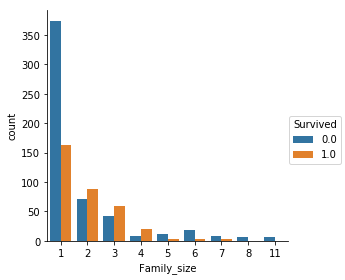

In [50]:
sns.factorplot(data = df, x = 'Family_size', hue = 'Survived', kind = 'count')

Text(0,0.5,'Survival Probability')

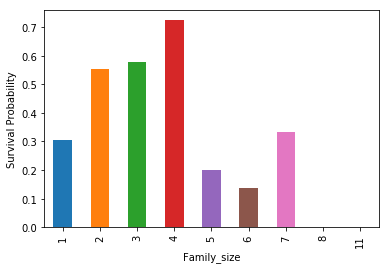

In [51]:
df.pivot_table(values = 'Survived', index = 'Family_size').Survived.plot.bar()
plt.ylabel('Survival Probability')

Now, family size with 2 to 4 members are more likely to survive. Thus, we will form bins for this groups.

In [52]:
df.loc[df['Family_size'] == 1, 'Family_size_bin'] = 0
df.loc[(df['Family_size'] >= 2) & (df['Family_size'] <= 4), 'Family_size_bin'] = 1
df.loc[df['Family_size'] >=5, 'Family_size_bin'] = 2

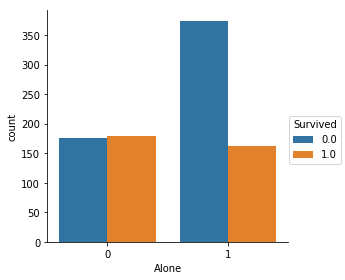

In [53]:
sns.factorplot(data = df, x = 'Alone', hue = 'Survived', kind = 'count')

Text(0,0.5,'Survival Probability')

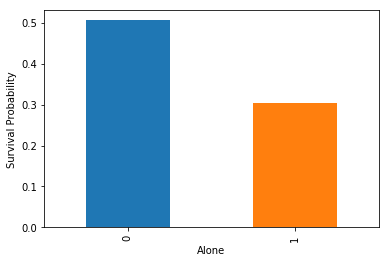

In [54]:
df.pivot_table(values = 'Survived', index = 'Alone').Survived.plot.bar()
plt.ylabel('Survival Probability')

People travelling alone are likely to less survive.

In [55]:
df['Title'] = df.Name.str.split(", ", expand = True)[1].str.split(".", expand = True)[0]
df.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
Mme               1
Sir               1
the Countess      1
Dona              1
Jonkheer          1
Don               1
Capt              1
Lady              1
Name: Title, dtype: int64

In [56]:
minor_titles = df.Title.value_counts() <= 4
df['Title'] = df.Title.apply(lambda x: 'Others' if minor_titles.loc[x] == True else x)
df.Title.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
Others     18
Rev         8
Dr          8
Name: Title, dtype: int64

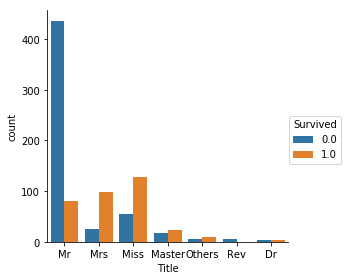

In [57]:
sns.factorplot(data = df, x = 'Title', hue = 'Survived', kind = 'count')

Text(0,0.5,'Survival Probability')

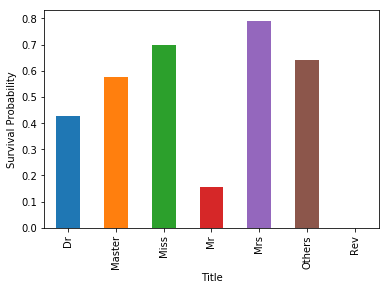

In [58]:
df.pivot_table(values = 'Survived', index = 'Title').Survived.plot.bar()
plt.ylabel('Survival Probability')

Lets make bins for age and fare also and visualize them.

In [59]:
df['Fare_bin'] = pd.qcut(df.Fare, 4, labels = [0,1,2,3]).astype(int)
df['Age_bin'] = pd.cut(df.Age.astype(int), 5, labels = [0,1,2,3,4]).astype(int)

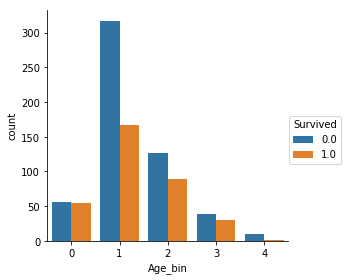

In [60]:
sns.factorplot(data = df, x = 'Age_bin', hue = 'Survived', kind = 'count')

Youngters are likely to survive more.

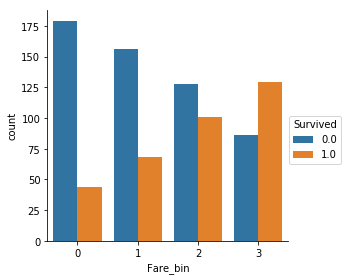

In [61]:
sns.factorplot(data = df, x = 'Fare_bin', hue = 'Survived', kind = 'count')

As much you pay, that much you will get security!

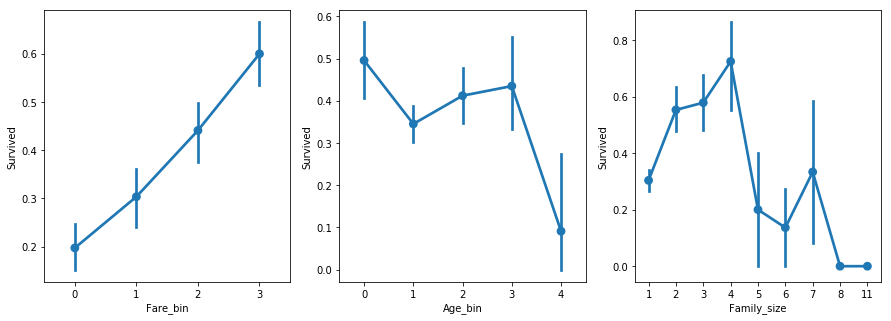

In [62]:
fig, axs = plt.subplots(1, 3,figsize=(15,5))

sns.pointplot(x = 'Fare_bin', y = 'Survived',  data=df, ax = axs[0])
sns.pointplot(x = 'Age_bin', y = 'Survived',  data=df, ax = axs[1])
sns.pointplot(x = 'Family_size', y = 'Survived', data=df, ax = axs[2])

### Handling categorical variables

In [63]:
label = LabelEncoder()
df['Title'] = label.fit_transform(df.Title)
df['Sex'] = label.fit_transform(df.Sex)
df['Embarked'] = label.fit_transform(df.Embarked)
df['Cabin'] = label.fit_transform(df.Cabin)

In [64]:
df.sample(2)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,label,Fare_log,Family_size,Alone,Family_size_bin,Title,Fare_bin,Age_bin
441,20.0,7,2,9.500,"Hampe, Mr. Leon",0,442,3,1,0,0.0,345769,train,2.251292,1,1,0.0,3,1,1
32,33.0,7,2,20.575,"Dean, Mrs. Bertram (Eva Georgetta Light)",2,924,3,0,1,NaN,C.A. 2315,test,3.024077,4,0,1.0,4,2,2


In [65]:
#We will look at correlation between variables. So before working with ticket column, save all variables we worked on yet.
#This id because we will use get_dummies on ticket and not label encoding.
corr_columns = list(df.drop(['Name', 'PassengerId', 'Ticket', 'label'], axis = 1).columns)

#### Ticket

In [66]:
df['Ticket'] = df.Ticket.map(lambda x: re.sub(r'\W+', '', x))   #Remove special characters

In [67]:
#If ticket is of digit value, make them a character X
Ticket = []
for i in list(df.Ticket):
    if not i.isdigit():
        Ticket.append(i[:2])
    else:
        Ticket.append("X")
df['Ticket'] = Ticket

In [68]:
df.Ticket.unique()

array(['A5', 'PC', 'ST', 'X', 'PP', 'CA', 'SC', 'A4', 'SP', 'SO', 'WC',
       'WE', 'C1', 'Fa', 'LI', 'FC', 'SW', 'C7', 'AS', 'C4', 'AQ', 'A2',
       'LP'], dtype=object)

In [69]:
df = pd.get_dummies(df, columns = ['Ticket'], prefix = 'T')

Now we will select features from the dataset for modelling purpose.

### Feature Selection

In [70]:
cat_variables = [x for x in df.columns if df.dtypes[x] == 'object']
cat_variables

['Name', 'label']

In [71]:
df.drop(['Name', 'PassengerId'], axis = 1, inplace = True)

In [72]:
df.sample(2)

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,label,...,T_PC,T_PP,T_SC,T_SO,T_SP,T_ST,T_SW,T_WC,T_WE,T_X
540,36.0,1,2,71.0,2,1,0,0,1.0,train,...,0,0,0,0,0,0,0,0,1,0
718,25.0,7,1,15.5,0,3,1,0,0.0,train,...,0,0,0,0,0,0,0,0,0,1


In [73]:
train = df.loc[df.label == 'train'].drop('label', axis = 1)
test = df.loc[df.label == 'test'].drop(['label', 'Survived'], axis = 1)

Lets look correlation between variables.

###### Pearson's

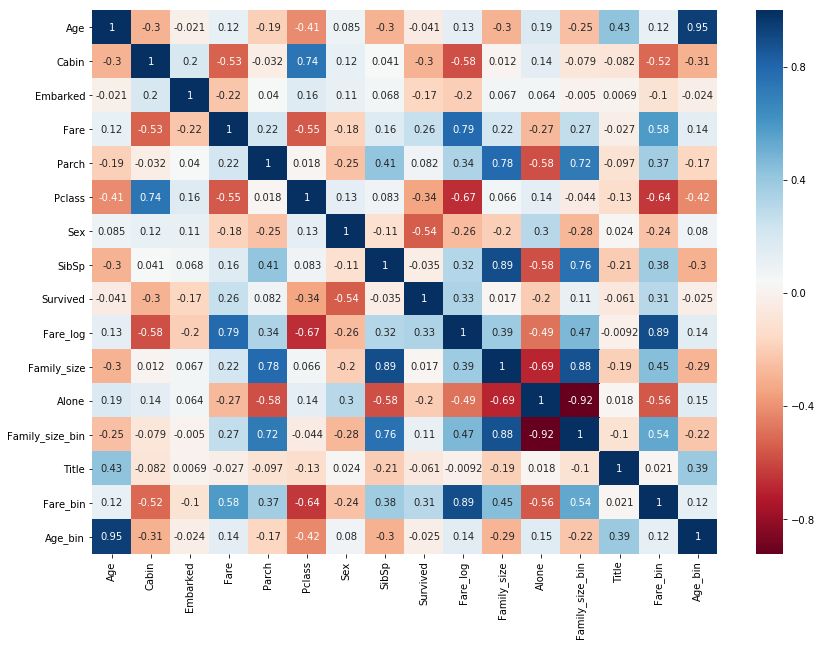

In [74]:
plt.figure(figsize = [14,10])
sns.heatmap(train[corr_columns].corr(), cmap = 'RdBu', annot = True)

1. Pclass and Cabin has some relations.
2. Offcourse Family_size will have relation with Parch and SibSp as it is derived from these two.

Lets look at spearman's correlation also. Note I'm looking this only for Fare variable as it is not skewed.

###### Spearman's

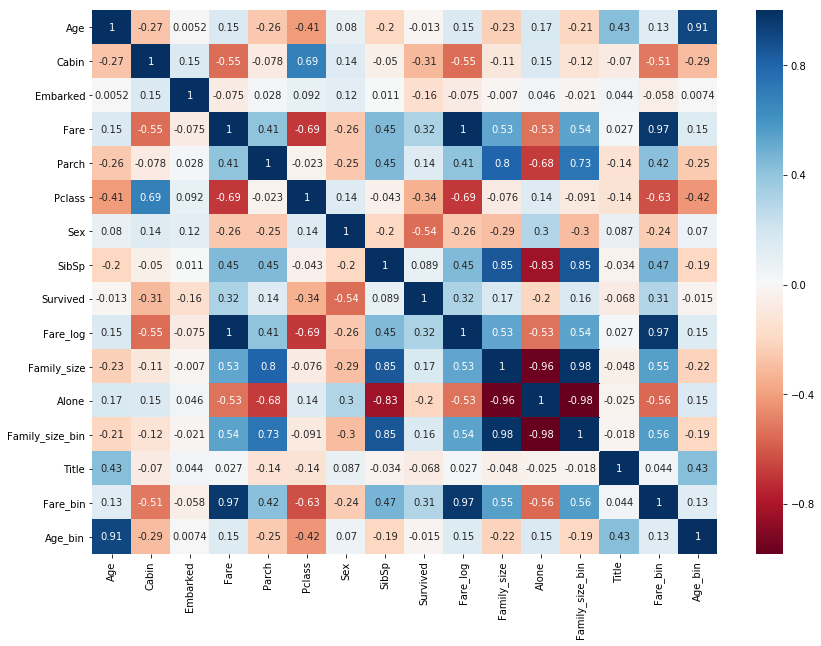

In [75]:
plt.figure(figsize = [14,10])
sns.heatmap(train[corr_columns].corr(method = 'spearman'), cmap = 'RdBu', annot = True)

As expected! Correlation are somewhat more stronger than pearson's (looking at more blue blocks in spearan's). Also, Fare_log and Fare have correlation 1 because one is just the log transformation of another. Thus, rank will be same.[](http://)

## Modeling

Split the data into train and test sets.

In [76]:
X_train = train.drop(['Survived'], axis = 1)
y_train = train['Survived'].astype(int)
X_test = test

In [77]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits = 5)

In [78]:
classifiers = []
classifiers.append(KNeighborsClassifier())
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LogisticRegression(random_state = 0))
classifiers.append(LinearSVC(random_state = 0))
classifiers.append(SVC(random_state = 0))
classifiers.append(RandomForestClassifier(random_state = 0))
classifiers.append(ExtraTreesClassifier(random_state = 0))
classifiers.append(XGBClassifier(random_state = 0))
classifiers.append(LGBMClassifier(random_state = 0))
classifiers.append(MLPClassifier())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = 'accuracy', cv = kfold, n_jobs = -1))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CV_means':cv_means, 'CV_std':cv_std, 'Algorithm':['KNN', 'LinearDiscriminantAnalysis', 'LogisticRegression', 'LinearSVC', 'SVC', 'RandomForest', 'ExtraTrees', 'XGB', 'LGB', 'MLP']})


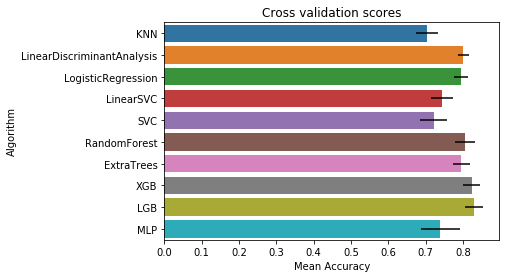

In [79]:
g = sns.barplot("CV_means", "Algorithm", data = cv_res, **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

We will use Linear Discriminant Analysis, Random Forest, Extra Trees, XGBoost, Light Gradient Boosting and Multi Layer Perceptron. This is because these all performed well and while using voting classifier, I don't want to bias the classifier. So I used two bagging models, two boosting models, linear model and neural network.[](http://)

#### Hyperparamter Tuning

Here I'm not using HPT for LDA. Reason behind this is there is no combination which makes some difference. Thus, best parameter will be the default parameters.

In [80]:
LDA_best = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [81]:
RF = RandomForestClassifier(random_state = 0)
RF_params = {'n_estimators' : [10,50,100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [5,8,None],
             'min_samples_split' : [2,5,8],
             'min_samples_leaf' : [1,3,5],
             'max_features' : ['auto', 'log2', None]}
GS_RF = GridSearchCV(RF, param_grid = RF_params, cv = kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)
GS_RF.fit(X_train, y_train)
RF_best = GS_RF.best_estimator_
print("Best parameters :", RF_best)
print("Best score :", GS_RF.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  4.3min finished


Best parameters : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Best score : 0.8406285072951739


In [82]:
ET = ExtraTreesClassifier(random_state = 0)
ET_params = {'n_estimators' : [10,50,100],
             'criterion' : ['gini', 'entropy'],
             'max_depth' : [5,8,None],
             'min_samples_split' : [2,5,8],
             'min_samples_leaf' : [1,3,5],
             'max_features' : ['auto', 'log2', None]}
GS_ET = GridSearchCV(ET, param_grid = ET_params, cv= kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)
GS_ET.fit(X_train, y_train)
ET_best = GS_ET.best_estimator_
print('Best parameters :', ET_best)
print('Best score :', GS_ET.best_score_)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  3.8min finished


Best parameters : ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=8,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
Best score : 0.835016835016835


In [83]:
XGB = XGBClassifier(random_state = 0)
XGB_params = {'n_estimators' : [100,200,500],
              'max_depth' : [3,4,5],
              'learning_rate' : [0.01,0.05,0.1,0.2],
              'booster' : ['gbtree', 'gblinear', 'dart']}
GS_XGB = GridSearchCV(XGB, param_grid = XGB_params, cv= kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)
GS_XGB.fit(X_train, y_train)
XGB_best = GS_XGB.best_estimator_
print('Best parameters :', XGB_best)
print('Best score :', GS_XGB.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  4.3min finished


Best parameters : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Best score : 0.8361391694725028


In [84]:
LGB = LGBMClassifier(random_state = 0)
LGB_params = {'n_estimators' : [100,200,500],
              'max_depth' : [5,8,-1],
              'learning_rate' : [0.01,0.05,0.1,0.2],
              'boosting_type' : ['gbdt', 'goss', 'dart']}
GS_LGB = GridSearchCV(LGB, param_grid = LGB_params, cv= kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)
GS_LGB.fit(X_train, y_train)
LGB_best = GS_LGB.best_estimator_
print('Best parameters :', LGB_best)
print('Best score :', GS_LGB.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  3.6min finished


Best parameters : LGBMClassifier(boosting_type='goss', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=5, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)
Best score : 0.8428731762065096


In [85]:
MLP = MLPClassifier(random_state = 0)
MLP_params = {'hidden_layer_sizes' : [[10], [10,10], [10,100], [100,100]],
              'activation' : ['relu', 'tanh', 'logistic'],
              'alpha' : [0.0001,0.001,0.01]}
GS_MLP = GridSearchCV(MLP, param_grid = MLP_params, cv= kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)
GS_MLP.fit(X_train, y_train)
MLP_best = GS_MLP.best_estimator_
print('Best parameters :', MLP_best)
print('Best score :', GS_MLP.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.2min finished


Best parameters : MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[100, 100], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)
Best score : 0.7901234567901234


### Plot Feature Importance

We will plot feature importances of 4 classifiers excluding LDA and MLP. LDA and MLP doesnot have attribute feature_importances_. For linear models, finding feature importance or parameter influence depends on various techniques i.e., p-values, bootstrap scores, various discriminative indices, etc.

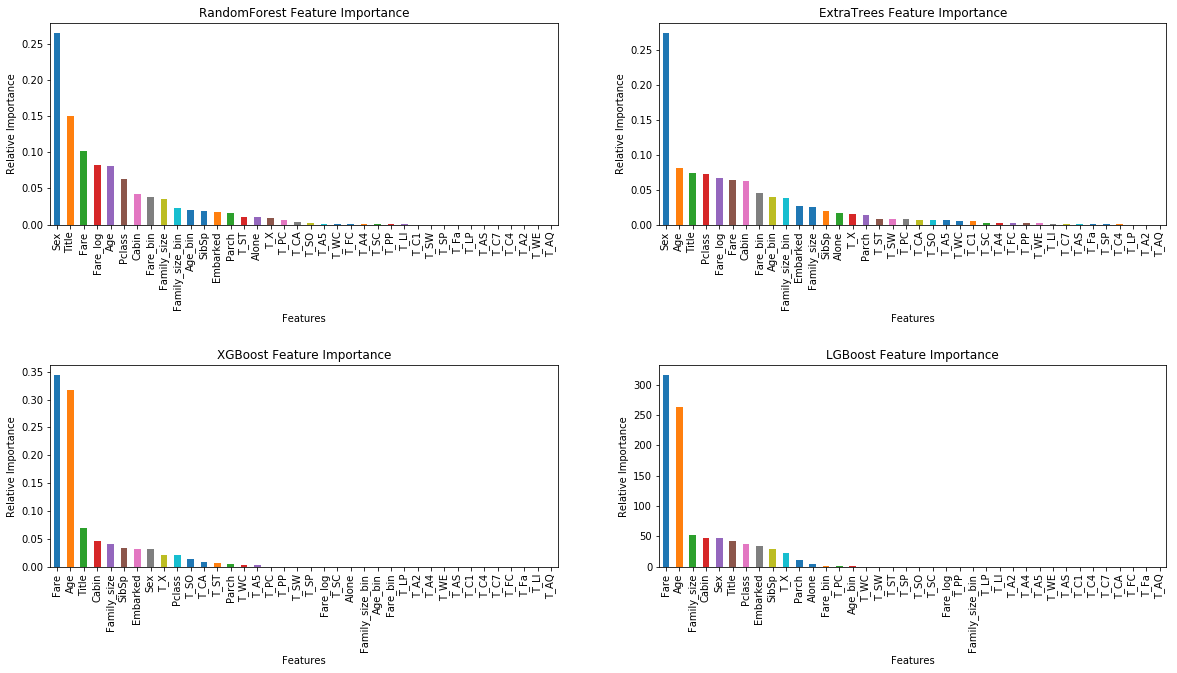

In [86]:
fig, axes = plt.subplots(2, 2, figsize = [20,10])
fig.subplots_adjust(hspace = 0.7)
classifiers_list = [["RandomForest", RF_best], ["ExtraTrees", ET_best],
                    ["XGBoost", XGB_best], ["LGBoost", LGB_best]]

nClassifier = 0
for row in range(2):
    for col in range(2):
        name = classifiers_list[nClassifier][0]
        classifier = classifiers_list[nClassifier][1]
        feature = pd.Series(classifier.feature_importances_, X_train.columns).sort_values(ascending = False)
        feature.plot.bar(ax = axes[row,col])
        axes[row,col].set_xlabel("Features")
        axes[row,col].set_ylabel("Relative Importance")
        axes[row,col].set_title(name + " Feature Importance")
        nClassifier +=1

1. RF and ET used more features for prediction whereas boosters gave Fare and Age variable higher weightage.
2. Bins formed were used by trees whereas boosters did not use bins at all inspite of using Fare and Age variable for predictions.

###### Reasons to keep linear model and MLP:
We have created features of variables by forming bins i.e., Fare_bin, Age_bin, etc. Now, linear models, SVC and MLP have tendency to predict better when bins are formed from a feature whereas boosters don't give importance to bins and they use other parameters for classification. Also we saw that trees also used bins features for their prediction. Thus, combining models which classifies the data based on different features is want we want. Thus, I've kept two linear models with trees.

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


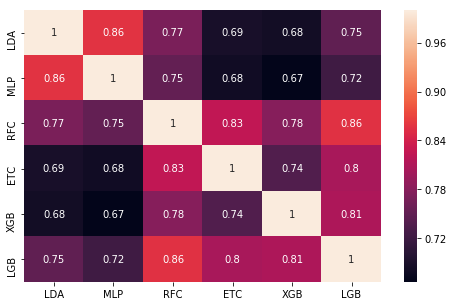

In [87]:
LDA_pred = pd.Series(LDA_best.predict(X_test), name = 'LDA')
MLP_pred = pd.Series(MLP_best.predict(X_test), name = "MLP")
RF_pred = pd.Series(RF_best.predict(X_test), name = "RFC")
ET_pred = pd.Series(ET_best.predict(X_test), name = 'ETC')
XGB_pred = pd.Series(XGB_best.predict(X_test), name = "XGB")
LGB_pred = pd.Series(LGB_best.predict(X_test), name = "LGB")

ensemble_results = pd.concat([LDA_pred, MLP_pred, RF_pred, ET_pred, XGB_pred, LGB_pred], axis = 1)
plt.figure(figsize = [8,5])
sns.heatmap(ensemble_results.corr(), annot = True)

So, we can see that the predictions made by linear models, trees and boosters are quite different. Now, we will make our final output based on VotingClassifier.

### Ensemble Modelling

In [88]:
voting = VotingClassifier(estimators = [['LDA', LDA_best], ["MLP", MLP_best],
                                        ['RFC', RF_best], ['ETC', ET_best],
                                        ['XGB', XGB_best], ['LGB', LGB_best]], voting = 'soft', n_jobs = -1)
voting = voting.fit(X_train, y_train)

I've kept voting = 'soft' because for each case, I want the result of that classifier that makes more confident prediction i.e., prediction with more probability.

In [89]:
results = pd.DataFrame(test_passengerId, columns = ['PassengerId']).assign(Survived = pd.Series(voting.predict(X_test)))
#results.to_csv('models_voting.csv', index = None)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
